In [103]:
%load_ext autoreload
%autoreload 2
root_dir = r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src'))
sys.path.insert(0, os.path.join(project_root, 'utils'))
# project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
# print(sys.path)  # Verify the paths are added

In [105]:
from process_yoga_video import process_yoga_video

> Currently, we are getting HOLD phase features after we are sure of holding the pose for 0.5 seconds

SHAPE OF VELOCITY MAGNITUDE: torch.Size([10539, 33])
SHAPE OF SMOOTHED VELOCITY: torch.Size([10539])
Movement detected at frame 1
Hold phase detected at frame 154
HOLD FRAME FEATURES SHAPE: torch.Size([5, 33, 3])
Joint Angles at Frame 183:
0: {'right_shoulder_3d': tensor(174.2156, dtype=torch.float64), 'left_shoulder_3d': tensor(156.9292, dtype=torch.float64), 'right_elbow_3d': tensor(152.8174, dtype=torch.float64), 'left_elbow_3d': tensor(142.5870, dtype=torch.float64), 'right_hip_3d': tensor(171.7372, dtype=torch.float64), 'left_hip_3d': tensor(170.4137, dtype=torch.float64), 'right_knee_3d': tensor(168.4358, dtype=torch.float64), 'left_knee_3d': tensor(171.9270, dtype=torch.float64), 'right_ankle_3d': tensor(121.4553, dtype=torch.float64), 'left_ankle_3d': tensor(126.5456, dtype=torch.float64)}
1: {'right_shoulder_3d': tensor(174.6417, dtype=torch.float64), 'left_shoulder_3d': tensor(156.8934, dtype=torch.float64), 'right_elbow_3d': tensor(152.5409, dtype=torch.float64), 'left_elbow

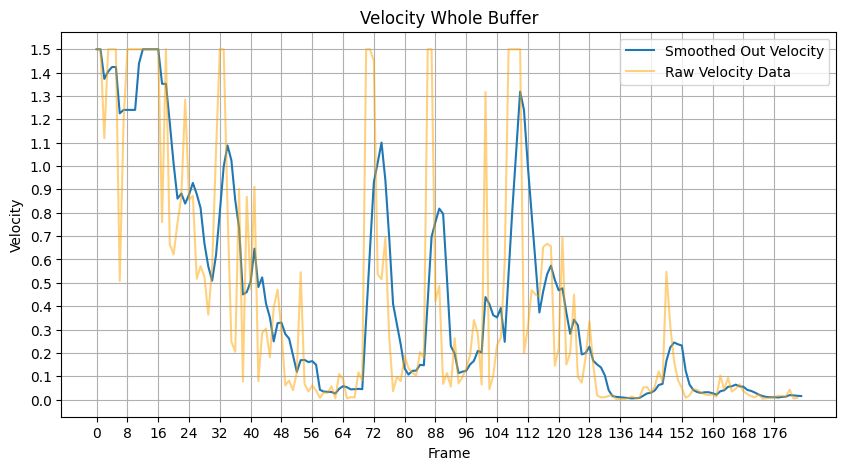

{0: (<PoseState.WAITING: 'waiting'>, 1), 1: (<PoseState.MOVEMENT: 'movement'>, 183), 184: (<PoseState.HOLD: 'hold'>, 0)}


In [78]:
video_path = os.path.join(root_dir, "tiktok_data/mountain/first.mp4")
s = process_yoga_video(video_path)

In [116]:
joint_angle_values = s[1]

In [115]:
joint_configs = {
        # Upper body
        'right_shoulder': {
            'joints': (13, 11, 23),  # right_elbow, right_shoulder, right_hip
            'joint_names': ('right_elbow', 'right_shoulder', 'right_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_shoulder': {
            'joints': (14, 12, 24),  # left_elbow, left_shoulder, left_hip
            'joint_names': ('left_elbow', 'left_shoulder', 'left_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_elbow': {
            'joints': (11, 13, 15),  # right_shoulder, right_elbow, right_wrist
            'joint_names': ('right_shoulder', 'right_elbow', 'right_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_elbow': {
            'joints': (12, 14, 16),  # left_shoulder, left_elbow, left_wrist
            'joint_names': ('left_shoulder', 'left_elbow', 'left_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        
        # Lower body
        'right_hip': {
            'joints': (11, 23, 25),  # right_shoulder, right_hip, right_knee
            'joint_names': ('right_shoulder', 'right_hip', 'right_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_hip': {
            'joints': (12, 24, 26),  # left_shoulder, left_hip, left_knee
            'joint_names': ('left_shoulder', 'left_hip', 'left_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_knee': {
            'joints': (23, 25, 27),  # right_hip, right_knee, right_ankle
            'joint_names': ('right_hip', 'right_knee', 'right_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'left_knee': {
            'joints': (24, 26, 28),  # left_hip, left_knee, left_ankle
            'joint_names': ('left_hip', 'left_knee', 'left_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'right_ankle': {
            'joints': (25, 27, 31),  # right_knee, right_ankle, right_foot_index
            'joint_names': ('right_knee', 'right_ankle', 'right_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_ankle': {
            'joints': (26, 28, 32),  # left_knee, left_ankle, left_foot_index
            'joint_names': ('left_knee', 'left_ankle', 'left_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        }
}

In [117]:
# removes _3d prefix
jav = {}
for k, v in joint_angle_values.items():
    jav[k] = {ik[:-3]: iv for ik, iv in v.items()}

In [118]:
jav[0]
detailed_jav = {}
for k, v in jav[0].items():
    reference_joints = joint_configs[k]['joint_names']
    detailed_jav[k] = (reference_joints, v)
    # print(reference_joints)
    
detailed_jav

{'right_shoulder': (('right_elbow', 'right_shoulder', 'right_hip'),
  tensor(174.2156, dtype=torch.float64)),
 'left_shoulder': (('left_elbow', 'left_shoulder', 'left_hip'),
  tensor(156.9292, dtype=torch.float64)),
 'right_elbow': (('right_shoulder', 'right_elbow', 'right_wrist'),
  tensor(152.8174, dtype=torch.float64)),
 'left_elbow': (('left_shoulder', 'left_elbow', 'left_wrist'),
  tensor(142.5870, dtype=torch.float64)),
 'right_hip': (('right_shoulder', 'right_hip', 'right_knee'),
  tensor(171.7372, dtype=torch.float64)),
 'left_hip': (('left_shoulder', 'left_hip', 'left_knee'),
  tensor(170.4137, dtype=torch.float64)),
 'right_knee': (('right_hip', 'right_knee', 'right_ankle'),
  tensor(168.4358, dtype=torch.float64)),
 'left_knee': (('left_hip', 'left_knee', 'left_ankle'),
  tensor(171.9270, dtype=torch.float64)),
 'right_ankle': (('right_knee', 'right_ankle', 'right_foot_index'),
  tensor(121.4553, dtype=torch.float64)),
 'left_ankle': (('left_knee', 'left_ankle', 'left_foot_i

In [126]:
import torch
formatted_data = {}
for joint, data in detailed_jav.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[0]
        else:
            angle = data
        
        # Convert tensor to float
        # if isinstance(angle, torch.Tensor):
        #     formatted_data[joint] = float(angle)
        # else:
        #     formatted_data[joint] = float(angle)
        formatted_data[joint] = angle
formatted_data 

{'right_shoulder': ('right_elbow', 'right_shoulder', 'right_hip'),
 'left_shoulder': ('left_elbow', 'left_shoulder', 'left_hip'),
 'right_elbow': ('right_shoulder', 'right_elbow', 'right_wrist'),
 'left_elbow': ('left_shoulder', 'left_elbow', 'left_wrist'),
 'right_hip': ('right_shoulder', 'right_hip', 'right_knee'),
 'left_hip': ('left_shoulder', 'left_hip', 'left_knee'),
 'right_knee': ('right_hip', 'right_knee', 'right_ankle'),
 'left_knee': ('left_hip', 'left_knee', 'left_ankle'),
 'right_ankle': ('right_knee', 'right_ankle', 'right_foot_index'),
 'left_ankle': ('left_knee', 'left_ankle', 'left_foot_index')}

In [200]:
import torch
from typing import Dict, Tuple, List, Any, Union

ACTION_JOINT_MAPPING = {
    'T_pose': ['right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow'],
    'warrior_pose': ['right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_ankle', 'left_ankle'],
    'tree_pose': ['right_hip', 'left_hip', 'right_knee', 'left_knee', 'right_ankle', 'left_ankle'],
    'mountain': ['right_ankle', 'left_ankle', 'right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_shoulder', 'left_shoulder']
}

TARGET_ANGLES = {
    'T_pose': {
        'right_shoulder': 180.0,
        'left_shoulder': 180.0,
        'right_elbow': 180.0,
        'left_elbow': 180.0
    },
    'warrior_pose': {
        'right_knee': 90.0,  # Front knee bent at 90 degrees
        'left_knee': 170.0, # Back leg relatively straight, slight bend to avoid hyperextension
        'right_hip': 170.0, # Open hip, but not excessively so
        'left_hip': 170.0,
        'right_ankle': 90.0,
        'left_ankle': 90.0
    },
    'mountain': {
        'right_ankle': 130, # Ideally straight, but allow for slight variations
        'left_ankle': 130,
        'right_knee': 175.0, # Not locked, slight bend to prevent hyperextension
        'left_knee': 175.0,
        'right_hip': 180.0,
        'left_hip': 180.0,
        'right_shoulder': 180.0,
        'left_shoulder': 180.0
    }
}

def format_angle_data(angle_data: Dict[str, Union[Tuple, torch.Tensor]]) -> Dict[str, float]:
    """
    Convert the raw angle data into a clean dictionary of float values
    """
    formatted_data = {}
    for joint, data in angle_data.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[1]
        else:
            angle = data
        
        # Convert tensor to float
        if isinstance(angle, torch.Tensor):
            formatted_data[joint] = float(angle)
        else:
            formatted_data[joint] = float(angle)
    
    return formatted_data

def generate_pose_feedback_prompt(
    user_angles: Dict[str, Any],
    target_angles: Dict[str, Any],
    action_type: str,
    joint_configs: Dict[str, Dict[str, Any]]
) -> str:
    """
    Generate a structured prompt for pose feedback
    
    Parameters:
    - user_angles: Dictionary of current user joint angles
    - target_angles: Dictionary of target joint angles
    - action_type: Type of pose/action being performed
    - joint_configs: Configuration dictionary containing joint relationships
    
    Returns:
    - Formatted prompt string
    """
    # Format the angle data
    # print(user_angles)
    user_angles_clean = format_angle_data(user_angles)
    target_angles_clean = format_angle_data(target_angles)
    
    # print("User Angles Clean:", user_angles_clean)
    # print("Target Angles Clean:", target_angles_clean)
    # Get relevant joints for this action
    relevant_joints = ACTION_JOINT_MAPPING.get(action_type, [])
    # print("Relevant Joints:", relevant_joints) 
    # Build the prompt
    prompt_parts = [
        f"Action: {action_type} Pose\n",
        "Current Joint Analysis:\n"
    ]
    
    # Add joint-specific information
    for joint in relevant_joints:
        if joint in user_angles_clean and joint in target_angles_clean:
            current_angle = user_angles_clean[joint]
            target_angle = target_angles_clean[joint]
            # print(current_angle)
            
            # Get involved body parts from joint_configs
            involved_parts = joint_configs[joint]['joint_names']
            
            prompt_parts.append(
                f"- {joint.replace('_', ' ').title()}:\n"
                f"  Current: {current_angle:.1f}°\n"
                f"  Target: {target_angle:.1f}°\n"
                f"  Involved parts: {', '.join(involved_parts)}\n"
            )
    
    # Add instruction for the language model
    prompt_parts.extend([
        "\nContext:",
        f"- This is a {action_type.replace('_', ' ')} position",
        "- Angles represent the degree between connected body parts",
        "- 180° represents a straight line\n",
        "Task: Based on these angles, provide clear, simple feedback in 20-30 words",
        "focusing on the most important corrections needed for proper form.",
        "Prioritize larger deviations and maintain bilateral symmetry where appropriate.",
        "Don't use numbers simply use words used by a typical yoga coach or a fitness coach, but use simple words."
    ])
    
    return "\n".join(prompt_parts)

In [203]:
prompt = generate_pose_feedback_prompt(detailed_jav, TARGET_ANGLES['mountain'], 'mountain', joint_configs)
print(prompt)

Action: mountain Pose

Current Joint Analysis:

- Right Ankle:
  Current: 121.5°
  Target: 130.0°
  Involved parts: right_knee, right_ankle, right_foot_index

- Left Ankle:
  Current: 126.5°
  Target: 130.0°
  Involved parts: left_knee, left_ankle, left_foot_index

- Right Knee:
  Current: 168.4°
  Target: 175.0°
  Involved parts: right_hip, right_knee, right_ankle

- Left Knee:
  Current: 171.9°
  Target: 175.0°
  Involved parts: left_hip, left_knee, left_ankle

- Right Hip:
  Current: 171.7°
  Target: 180.0°
  Involved parts: right_shoulder, right_hip, right_knee

- Left Hip:
  Current: 170.4°
  Target: 180.0°
  Involved parts: left_shoulder, left_hip, left_knee

- Right Shoulder:
  Current: 174.2°
  Target: 180.0°
  Involved parts: right_elbow, right_shoulder, right_hip

- Left Shoulder:
  Current: 156.9°
  Target: 180.0°
  Involved parts: left_elbow, left_shoulder, left_hip


Context:
- This is a mountain position
- Angles represent the degree between connected body parts
- 180° re

In [196]:
# Use Groq API to prompt Llama 7B model
from groq import Groq
from dotenv import load_dotenv
import os
load_dotenv()
client = Groq(api_key=os.getenv("GROQ_API_KEY"))  

completion = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[
        {
            "role": "system", 
            "content": "You are a helpful fitness coach providing precise, constructive feedback."
        },
        {
            "role": "user", 
            "content": prompt
        }
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=True,
    stop=None,
)

model_feedback = ""
for chunk in completion:
    content = chunk.choices[0].delta.content or ""
    print(content, end="")
    model_feedback += content

# # Extract the model's feedback
# model_feedback = response.choices[0].message.content.strip()
# print(model_feedback)


Here are the key corrections for proper mountain pose form:

1. **Chest lifted, shoulders back**: Your right shoulder (168.2° below target) and left shoulder (24.1° below target) should be slouched, lift your chest and engage your shoulder blades.
2. **Align hips and knees**: Your right knee (6.6° below target) and left knee (3.1° above target) are slightly out of alignment. Make sure to engage your core and keep your weight evenly distributed in your hips and knees.
3. **Ankle dorsi-extension**: Focus on extending your right ankle (8.5° below target) and left ankle (3.5° below target) to maintain a neutral ankle position.

Start by focusing on these key areas and adjust your mountain pose accordingly.

In [197]:
print(model_feedback)

Here are the key corrections for proper mountain pose form:

1. **Chest lifted, shoulders back**: Your right shoulder (168.2° below target) and left shoulder (24.1° below target) should be slouched, lift your chest and engage your shoulder blades.
2. **Align hips and knees**: Your right knee (6.6° below target) and left knee (3.1° above target) are slightly out of alignment. Make sure to engage your core and keep your weight evenly distributed in your hips and knees.
3. **Ankle dorsi-extension**: Focus on extending your right ankle (8.5° below target) and left ankle (3.5° below target) to maintain a neutral ankle position.

Start by focusing on these key areas and adjust your mountain pose accordingly.
